Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

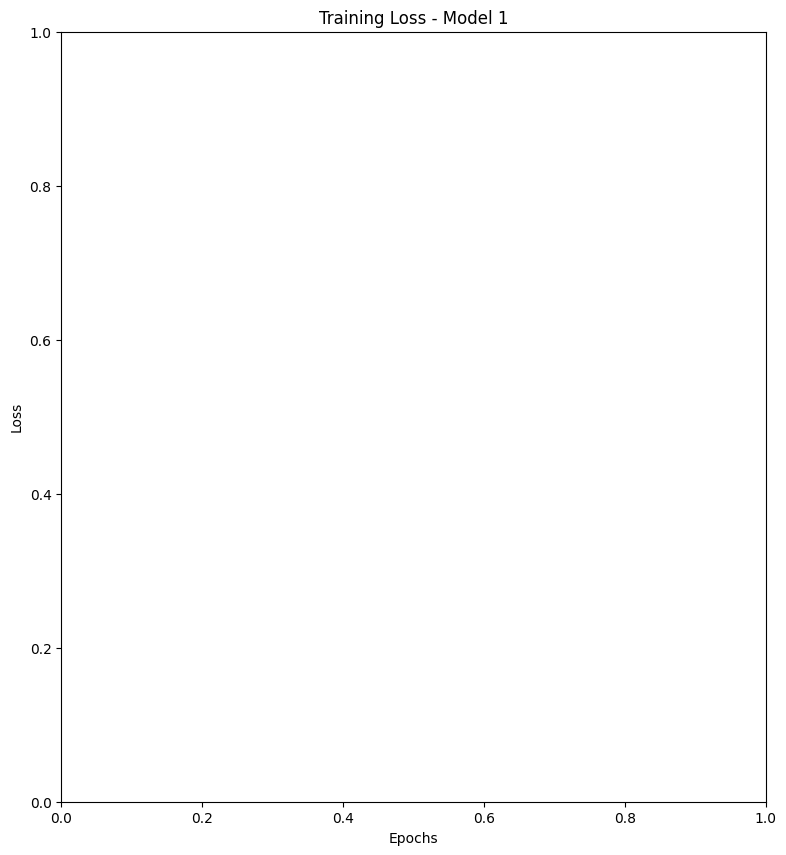

In [81]:
import torch.nn.functional as F
import torch.nn as layers
import torch.optim as optimizers
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from videoDataLoaderTest import dataset
from torch.utils.data import DataLoader, Dataset
import seaborn as sn
import time
import csv
import os
from plot_confusion_matrix import plot_confusion_matrix
import matplotlib.pyplot as plt 
from IPython.core.interactiveshell import InteractiveShell
from Regular_3D_2D_Hybrid_Extra_Conv2d import Regular_Plus_2dModel
from ELU_3D_2D_Hybrid_Extra_Conv2d import ELU_Plus_2dModel
from ELU_3D_2D_Hybrid import ELUModel
InteractiveShell.ast_node_interactivity = "all"
class Hybrid_3D_2D(layers.Module): # layers.Module is what the Hybrid_3D_2d will inherit methods from
    # Input layers.Module 
    #
    #
    #
    # Output
    def __init__(self):
        # Input self 
        #
        #
        # 
        # Output 

        super(Hybrid_3D_2D, self).__init__() # 
        
        self.cn1 = layers.Conv3d(in_channels = 30,out_channels = 8,kernel_size = 7, padding = 3) # the images are in  coluor channel and 29 tensors 
        self.cn2 = layers.Conv3d(in_channels = 8,out_channels = 16,kernel_size = 5, padding = 2)
        self.cn3 = layers.Conv3d(in_channels = 16,out_channels=32, kernel_size = 3, padding = 1)
        #
        #self.cn1_additional = layers.Conv3d(in_channels = 32,out_channels=64, kernel_size = 3, padding = 1)
        #self.cn2_additional = layers.Conv3d(in_channels = 64,out_channels=128, kernel_size = 3, padding = 1)
        #self.cn3_additional = layers.Conv3d(in_channels = 128,out_channels=256, kernel_size = 3, padding = 1)
        # self.cn4_2d = layers.Conv2d(in_channels = 256, out_channels = 64, kernel_size = 3, padding = 1) # padding for new layers need to be calculated 

        self.cn4_2d = layers.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1) # padding for new layers need to be calculated 
        


        # size > reduce the input from 3d > 2d layer
        # 2d layer output to be flattened 
        
        self.dropout5 = layers.Dropout(0.4)
        self.fc5 = layers.Linear(64 * 64 * 64 ,256)
        #dropout > 0.4
        self.dropout6 = layers.Dropout(0.4)
        self.fc6 = layers.Linear(256,128)
        self.fc7 = layers.Linear(128,2)
        #dropout > 0.4

    def forward(self,x):

        output = self.cn1(x)
        output = F.relu(output)

        
        output = self.cn2(output)
        output = F.relu(output)

        
        output = self.cn3(output)
        output = F.relu(output) # activaltion function

    
        
        output = output.reshape(output.size(0), 32,64,64)
        
        
        output = self.cn4_2d(output)
        
        output = F.relu(output)
        

        output = output.flatten(start_dim=1) # flattens output so that it can be fed into the linear layer

        output = self.fc5(output)
        output = F.relu(output)
        output = self.dropout5(output)


        output = self.fc6(output)
        output = F.relu(output)
        output = self.dropout6(output)
        

        output = self.fc7(output)

        #output = F.softmax(output,dim = 0) # since there are 2 classes 

        return output







# code adapted from :https://niruhan.medium.com/drawing-loss-curves-for-deep-neural-network-training-in-pytorch-ac617b24c388
# adaptation : removed the part of the code that plots the testing loss and added x and y labels
# Viswarupan, N.,(2021). Drawing Loss Curves for Deep Neural Network Training. Medium. https://niruhan.medium.com/drawing-loss-curves-for-deep-neural-network-training-in-pytorch-ac617b24c388  

y_loss = {}  # loss history
y_loss['train'] = []
y_loss['val'] = []
y_err = {}
y_err['train'] = []
y_err['val'] = []


x_epoch = []
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(121, title="Training Loss - Model 1") 
plt.ylabel('Loss')
plt.xlabel("Epochs")

def draw_curve_for_model_1_(current_epoch):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='Training Loss')
    if current_epoch == 0:
        ax0.legend()
        
    fig.savefig(os.path.join('./lossGraphs', 'train_loss_model_1.jpg'))



## end of code adapted from : 

def train(model,device,the_dataloader, optim,epochs,dataset_size,phase,batch_size):
    
    training_data_predictions = torch.tensor([]) # creates a tensor for storing the predictions of teh model 
    training_data_actual_values = torch.tensor([])
    
    
    model.train() # setd the model to training mode 
    
    for epoch in range(epochs):


        running_loss = 0.0 # sets loss for this epoch to 0
        running_corrects = 0.0 # sets actual truths to 0 for this epoch

        print("Current epoch" + str(epoch))

        #start_time = time.time()

        loss_list = []    
        batch_list = []

        predicted_y = []
        actual_y = []

        for batch_index, (X,y) in enumerate(the_dataloader):
            #X,y = X.to(device), y.to(device) # X is the input y is teh ground truth
            
            optim.zero_grad() # sets the gradients to 0 
            prediction = model(X) # gets the predictions made by teh model
            
            training_data_predictions = torch.cat((training_data_predictions, prediction),dim=0) # combines the predictions of the model for this batch and the ones from before
            training_data_actual_values = torch.cat((training_data_actual_values, y),dim=0) # adds the tensors with the actual values

            
            # parts of code below adapted from 
            if X.size == 4:
                current_batch_size, channels, height, width = X.shape
            else:
                current_batch_size, framesFed ,channels, height, width = X.shape


            if current_batch_size < batch_size: # skips smaller batch to plot the graph
                continue


            _, preds = torch.max(prediction.data, 1)
            loss = layers.CrossEntropyLoss()

            
            loss_result = loss(prediction,y) # to be chenged to a different one since it does softmax 
            
            
            del X

            
            #loss =  # calculates the loss

            loss_result.backward() # updates the weights 
            optim.step() # 
            
            running_loss+=loss_result.item() * current_batch_size

            del loss
            running_corrects+=float(torch.sum(preds == y.data))
             
            
            if (batch_index*30) % 30 == 0: # 
                print(batch_index)
                training_result_format = 'batch:({:.0f})|loss:({:.4f}) '.format(batch_index,loss_result)
                print(training_result_format)

    epoch_loss = running_loss/dataset_size # ;loss fpr this epoch
    epoch_acc = running_corrects / dataset_size # 
    y_loss[phase].append(epoch_loss)
    y_err[phase].append(1.0  - epoch_acc)

    
    draw_curve_for_model_1_(epoch) 

    return model,training_data_predictions,training_data_actual_values

def test(model,device,the_dataloader, optim,epochs,dataset_size,phase,batch_size):

    testing_data_predictions = torch.tensor([]) # creates a tensor for storing the predictions of teh model 
    testing_data_actual_values = torch.tensor([])
    
    start_time = time.time()

    for batch_index, (X,y) in enumerate(the_dataloader):
        model.eval()
        
        torch.no_grad()

        prediction = model(X) # gets the predictions made by teh model
        testing_data_predictions = torch.cat((testing_data_predictions, prediction),dim=0) # combines the predictions of the model for this batch and the ones from before
        testing_data_actual_values = torch.cat((testing_data_actual_values, y),dim=0) # adds the tensors with the actual values

        
        if X.size == 4:
            current_batch_size, channels, height, width = X.shape
        else:
            current_batch_size, framesFed ,channels, height, width = X.shape
        if current_batch_size < batch_size: # skips smaller batch to plot the graph
            continue
        _, preds = torch.max(prediction.data, 1)
        
        # end of adapted part 
        loss = layers.CrossEntropyLoss()
        
        loss_result = loss(prediction,y) # to be chenged to a different one since it does softmax 
        
        if (batch_index*30) % 30 == 0: # 
            print(batch_index)
            testing_result_format = 'batch:({:.0f})|loss:({:.4f}) '.format(batch_index,loss_result)
            print(testing_result_format)

        end_time = time.time()
        execution_time = end_time - start_time
        Regular_3D_2D_Hybrid_Time = open(('Model_1_Test_Time/time_file.txt'), "w" ) 
        Regular_3D_2D_Hybrid_Time.write("Testing time:" + str(execution_time) + "s" + "\n") 
        Regular_3D_2D_Hybrid_Time.close()

    return model,testing_data_predictions,testing_data_actual_values



ReLUModel = Hybrid_3D_2D()

optim = optimizers.SGD(ReLUModel.parameters(),lr=0.01)# transfer learning paper > used 0.0005 for transfer learning 

torch.manual_seed(65) # by setting a seed all random numbers generated can be made the same for all models

training_data, testing_data = torch.utils.data.random_split(dataset, [42,18])



load_training_data = DataLoader(dataset=training_data, batch_size=6, shuffle=3) 
load_testing_data = DataLoader(dataset=testing_data, batch_size=6, shuffle=3)


In [82]:
training_results = train(ReLUModel, 'cpu',load_training_data,optim,150,len(training_data),'train',batch_size=6) 

Current epoch0
0
batch:(0)|loss:(0.7106) 
1
batch:(1)|loss:(0.6666) 
2
batch:(2)|loss:(0.6806) 
3
batch:(3)|loss:(0.6971) 
4
batch:(4)|loss:(0.7178) 
5
batch:(5)|loss:(0.6964) 
6
batch:(6)|loss:(0.6924) 
Current epoch1
0
batch:(0)|loss:(0.6685) 
1
batch:(1)|loss:(0.6809) 
2
batch:(2)|loss:(0.7095) 
3
batch:(3)|loss:(0.6653) 
4
batch:(4)|loss:(0.6794) 
5
batch:(5)|loss:(0.7433) 
6
batch:(6)|loss:(0.7003) 
Current epoch2
0
batch:(0)|loss:(0.6590) 
1
batch:(1)|loss:(0.6932) 
2
batch:(2)|loss:(0.6781) 
3
batch:(3)|loss:(0.6801) 
4
batch:(4)|loss:(0.6844) 
5
batch:(5)|loss:(0.7168) 
6
batch:(6)|loss:(0.7129) 
Current epoch3
0
batch:(0)|loss:(0.6612) 
1
batch:(1)|loss:(0.6832) 
2
batch:(2)|loss:(0.7143) 
3
batch:(3)|loss:(0.6599) 
4
batch:(4)|loss:(0.6757) 
5
batch:(5)|loss:(0.6889) 
6
batch:(6)|loss:(0.7438) 
Current epoch4
0
batch:(0)|loss:(0.6996) 
1
batch:(1)|loss:(0.6762) 
2
batch:(2)|loss:(0.6689) 
3
batch:(3)|loss:(0.6796) 
4
batch:(4)|loss:(0.6958) 
5
batch:(5)|loss:(0.6934) 
6
batch

In [83]:
the_trained_3D_2D_Hybrid = training_results[0]

test_results = test(the_trained_3D_2D_Hybrid, 'cpu',load_testing_data,optim,150,len(testing_data),'val',batch_size=6) 

training_predictions = (training_results[1]).detach().argmax(dim=1)
training_data_actual_values = (training_results[2])

classes = ["No Violence","Violence"]

confusion_mat = confusion_matrix(training_predictions,training_data_actual_values)
plt.figure(figsize=(10,10))

0
batch:(0)|loss:(0.0469) 
1
batch:(1)|loss:(0.2307) 
2
batch:(2)|loss:(0.6023) 


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

[[3377 2207]
 [  73  643]]
<class 'numpy.ndarray'>


<Figure size 1000x1000 with 0 Axes>

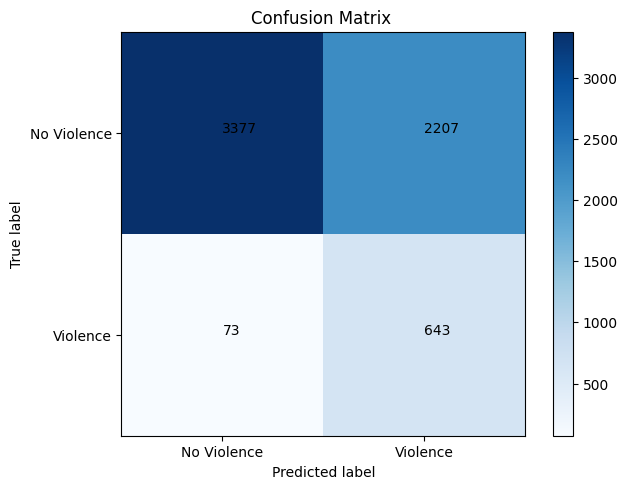

<Figure size 1000x1000 with 0 Axes>

In [84]:
## Model Confusion Matrix Plotting Section
plot_confusion_matrix(confusion_mat,classes,title='Confusion Matrix ')

print(type(confusion_mat))


plt.figure(figsize=(10,10))


## end of Plotting Section

In [85]:
testing_predictions = (test_results[1]).detach().argmax(dim=1)
testing_data_actual_values = (test_results[2])

classes = ["No Violence","Violence"]

confusion_mat = confusion_matrix(testing_predictions,testing_data_actual_values)

[[ 6  1]
 [ 1 10]]
<class 'numpy.ndarray'>


<Figure size 1000x1000 with 0 Axes>

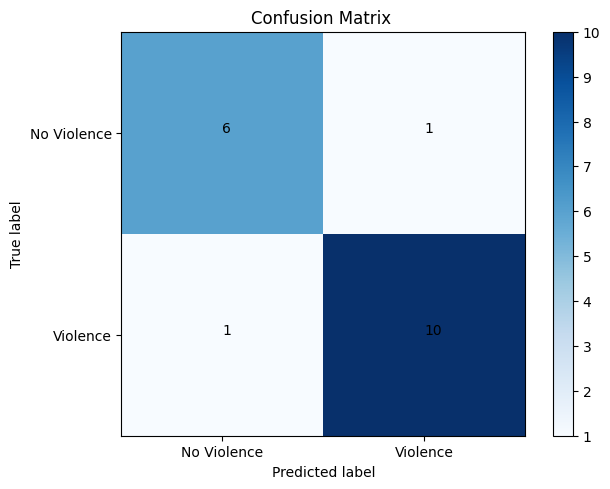

<Figure size 1000x1000 with 0 Axes>

In [86]:
## Model Confusion Matrix Plotting Section
plot_confusion_matrix(confusion_mat,classes,title='Confusion Matrix ')

print(type(confusion_mat))

plt.figure(figsize=(10,10))
plt.savefig(os.path.join('./Confusion Matrices', 'reg_model_confuse_matrix1.jpg'))

## end of Plotting Section

Model 2 - With Relu and extra 3 convolutional 3d layers

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

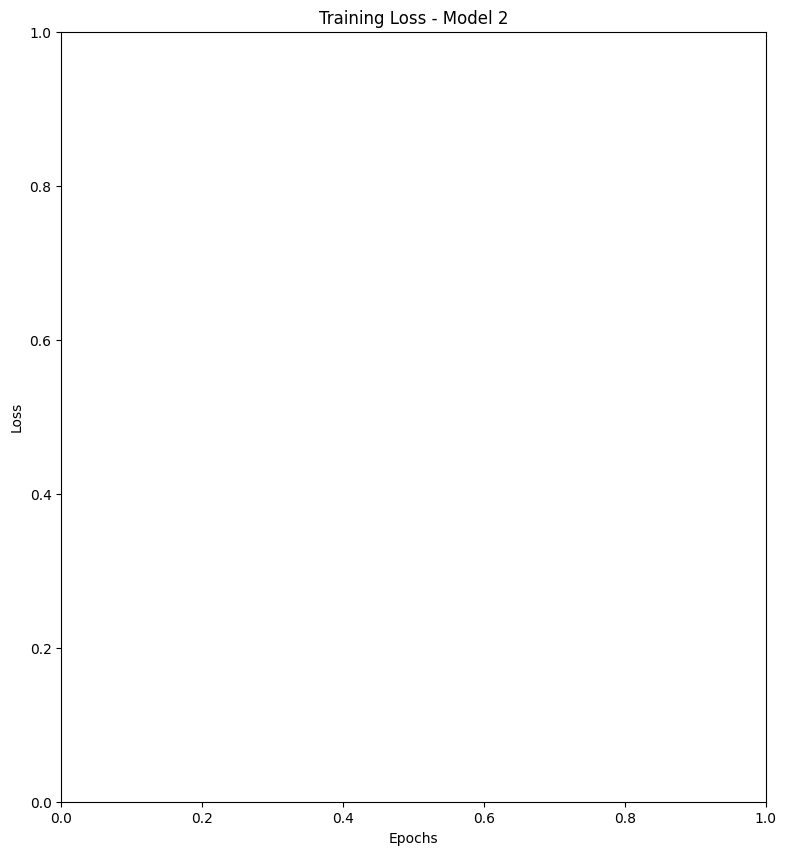

In [87]:
import torch.nn.functional as F
import torch.nn as layers
import torch.optim as optimizers
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from videoDataLoaderTest import dataset
from torch.utils.data import DataLoader, Dataset
import seaborn as sn
import time
import csv
import os
from plot_confusion_matrix import plot_confusion_matrix
import matplotlib.pyplot as plt 


from Regular_3D_2D_Hybrid_Extra_Conv2d import Regular_Plus_2dModel
from ELU_3D_2D_Hybrid_Extra_Conv2d import ELU_Plus_2dModel
from ELU_3D_2D_Hybrid import ELUModel


class Hybrid_3D_2D(layers.Module): # layers.Module is what the Hybrid_3D_2d will inherit methods from
    # Input layers.Module 
    #
    #
    #
    # Output
    def __init__(self):
        # Input self 
        #
        #
        # 
        # Output 

        super(Hybrid_3D_2D, self).__init__() # 
        
        self.cn1 = layers.Conv3d(in_channels = 30,out_channels = 8,kernel_size = 7, padding = 3) # the images are in  coluor channel and 29 tensors 
        self.cn2 = layers.Conv3d(in_channels = 8,out_channels = 16,kernel_size = 5, padding = 2)
        self.cn3 = layers.Conv3d(in_channels = 16,out_channels=32, kernel_size = 3, padding = 1)
        
        self.cn1_additional = layers.Conv3d(in_channels = 32,out_channels=64, kernel_size = 3, padding = 1)
        self.cn2_additional = layers.Conv3d(in_channels = 64,out_channels=128, kernel_size = 3, padding = 1)
        self.cn3_additional = layers.Conv3d(in_channels = 128,out_channels=256, kernel_size = 3, padding = 1)
        self.cn4_2d = layers.Conv2d(in_channels = 256, out_channels = 64, kernel_size = 3, padding = 1) # padding for new layers need to be calculated 

        # size > reduce the input from 3d > 2d layer
        # 2d layer output to be flattened 
        
        self.dropout5 = layers.Dropout(0.4)
        self.fc5 = layers.Linear(64 * 64 * 64 ,256)
        #dropout > 0.4
        self.dropout6 = layers.Dropout(0.4)
        self.fc6 = layers.Linear(256,128)
        self.fc7 = layers.Linear(128,2)
        #dropout > 0.4

    def forward(self,x):

        output = self.cn1(x)
        output = F.relu(output)

        
        output = self.cn2(output)
        output = F.relu(output)

        
        output = self.cn3(output)
        output = F.relu(output) # activaltion function

        output = self.cn1_additional(output)
        output = F.relu(output) # activaltion function

        output = self.cn2_additional(output)
        output = F.relu(output) # activaltion function

        output = self.cn3_additional(output)
        output = F.relu(output) # activaltion function
    
        
        output = output.reshape(output.size(0), 256,64,64) 
        
        
        output = self.cn4_2d(output)
        
        output = F.relu(output)
        

        output = output.flatten(start_dim=1) # flattens output so that it can be fed into the linear layer

        output = self.fc5(output)
        output = F.relu(output)
        output = self.dropout5(output)


        output = self.fc6(output)
        output = F.relu(output)
        output = self.dropout6(output)
        

        output = self.fc7(output) 

        return output

 
y_loss = {}  # loss history
y_loss['train'] = []
y_loss['val'] = []
y_err = {}
y_err['train'] = []
y_err['val'] = []

x_epoch = []
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(121, title="Training Loss - Model 2") 
plt.ylabel('Loss')
plt.xlabel("Epochs")


def draw_curve_for_model_2_(current_epoch):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='Training Loss')
    if current_epoch == 0:
        ax0.legend()
        
    fig.savefig(os.path.join('./lossGraphs', 'train_loss_model_2.jpg'))



def train(model,device,the_dataloader, optim,epochs,dataset_size,phase,batch_size):
    
    training_data_predictions = torch.tensor([]) # creates a tensor for storing the predictions of teh model 
    training_data_actual_values = torch.tensor([])
    
    
    model.train() # setd the model to training mode 
    
    for epoch in range(epochs):


        running_loss = 0.0 # sets loss for this epoch to 0
        running_corrects = 0.0 # sets actual truths to 0 for this epoch

        print("Current epoch" + str(epoch))

        #start_time = time.time()

        loss_list = []    
        batch_list = []

        predicted_y = []
        actual_y = []

        for batch_index, (X,y) in enumerate(the_dataloader):
            #X,y = X.to(device), y.to(device) # X is the input y is teh ground truth
            
            optim.zero_grad() # sets the gradients to 0 
            prediction = model(X) # gets the predictions made by teh model
            
            training_data_predictions = torch.cat((training_data_predictions, prediction),dim=0) # combines the predictions of the model for this batch and the ones from before
            training_data_actual_values = torch.cat((training_data_actual_values, y),dim=0) # adds the tensors with the actual values

            
            
            if X.size == 4:
                current_batch_size, channels, height, width = X.shape
            else:
                current_batch_size, framesFed ,channels, height, width = X.shape

            # start of code adapted from 
            if current_batch_size < batch_size: # skips smaller batch to plot the graph
                continue

            
            _, preds = torch.max(prediction.data, 1)
            loss = layers.CrossEntropyLoss()

            
            loss_result = loss(prediction,y) # to be chenged to a different one since it does softmax 
            
            # 
            del X

            
            #loss =  # calculates the loss

            loss_result.backward() # updates the weights 
            optim.step() # 
            
            running_loss+=loss_result.item() * current_batch_size

            del loss
            running_corrects+=float(torch.sum(preds == y.data))
             # 
            
            if (batch_index*30) % 30 == 0: # 
                print(batch_index)
                training_result_format = 'batch:({:.0f})|loss:({:.4f}) '.format(batch_index,loss_result)
                print(training_result_format)

    epoch_loss = running_loss/dataset_size # ;loss fpr this epoch
    epoch_acc = running_corrects / dataset_size # 
    y_loss[phase].append(epoch_loss)
    y_err[phase].append(1.0  - epoch_acc)

    draw_curve_for_model_2_(epoch)


    return model,training_data_predictions,training_data_actual_values

def test(model,device,the_dataloader, optim,epochs,dataset_size,phase,batch_size):

    testing_data_predictions = torch.tensor([]) # creates a tensor for storing the predictions of teh model 
    testing_data_actual_values = torch.tensor([])
    
    start_time = time.time()

    for batch_index, (X,y) in enumerate(the_dataloader):
        model.eval()
        
        torch.no_grad()

        prediction = model(X) # gets the predictions made by teh model
        testing_data_predictions = torch.cat((testing_data_predictions, prediction),dim=0) # combines the predictions of the model for this batch and the ones from before
        testing_data_actual_values = torch.cat((testing_data_actual_values, y),dim=0) # adds the tensors with the actual values

        # parts of code below adapted from 
        if X.size == 4:
            current_batch_size, channels, height, width = X.shape
        else:
            current_batch_size, framesFed ,channels, height, width = X.shape
        if current_batch_size < batch_size: # skips smaller batch to plot the graph
            continue
        _, preds = torch.max(prediction.data, 1)
        
        loss = layers.CrossEntropyLoss()
        
        loss_result = loss(prediction,y) # to be chenged to a different one since it does softmax 
        
        if (batch_index*30) % 30 == 0: # 
            print(batch_index)
            testing_result_format = 'batch:({:.0f})|loss:({:.4f}) '.format(batch_index,loss_result)
            print(testing_result_format)

        end_time = time.time()
        execution_time = end_time - start_time
        Regular_3D_2D_Hybrid_Time = open(('Model_2_Test_Time/time_file.txt'), "w" ) 
        Regular_3D_2D_Hybrid_Time.write("Testing time:" + str(execution_time) + "s" + "\n") 
        Regular_3D_2D_Hybrid_Time.close()

    return model,testing_data_predictions,testing_data_actual_values



ReLUModel_2 = Hybrid_3D_2D()

optim = optimizers.SGD(ReLUModel_2.parameters(),lr=0.01)# transfer learning paper > used 0.0005 for transfer learning 





In [88]:
training_results = train(ReLUModel_2, 'cpu',load_training_data,optim,150,len(training_data),'train',batch_size=6) 

Current epoch0
0
batch:(0)|loss:(0.7064) 
1
batch:(1)|loss:(0.6791) 
2
batch:(2)|loss:(0.7003) 
3
batch:(3)|loss:(0.6966) 
4
batch:(4)|loss:(0.7039) 
5
batch:(5)|loss:(0.6975) 
6
batch:(6)|loss:(0.6942) 
Current epoch1
0
batch:(0)|loss:(0.7031) 
1
batch:(1)|loss:(0.7132) 
2
batch:(2)|loss:(0.6995) 
3
batch:(3)|loss:(0.6909) 
4
batch:(4)|loss:(0.7098) 
5
batch:(5)|loss:(0.6887) 
6
batch:(6)|loss:(0.6868) 
Current epoch2
0
batch:(0)|loss:(0.6958) 
1
batch:(1)|loss:(0.7019) 
2
batch:(2)|loss:(0.6910) 
3
batch:(3)|loss:(0.6934) 
4
batch:(4)|loss:(0.6794) 
5
batch:(5)|loss:(0.6964) 
6
batch:(6)|loss:(0.7012) 
Current epoch3
0
batch:(0)|loss:(0.7039) 
1
batch:(1)|loss:(0.6913) 
2
batch:(2)|loss:(0.6870) 
3
batch:(3)|loss:(0.6924) 
4
batch:(4)|loss:(0.6862) 
5
batch:(5)|loss:(0.6963) 
6
batch:(6)|loss:(0.6901) 
Current epoch4
0
batch:(0)|loss:(0.6954) 
1
batch:(1)|loss:(0.6887) 
2
batch:(2)|loss:(0.6980) 
3
batch:(3)|loss:(0.6959) 
4
batch:(4)|loss:(0.6932) 
5
batch:(5)|loss:(0.6929) 
6
batch

In [89]:
the_trained_3D_2D_Hybrid = training_results[0]


test_results = test(the_trained_3D_2D_Hybrid, 'cpu',load_testing_data,optim,150,len(testing_data),'val',batch_size=6) 

training_predictions = (training_results[1]).detach().argmax(dim=1)
training_data_actual_values = (training_results[2])

classes = ["No Violence","Violence"]

confusion_mat = confusion_matrix(training_predictions,training_data_actual_values)
plt.figure(figsize=(10,10))

0
batch:(0)|loss:(0.6658) 
1
batch:(1)|loss:(0.6977) 
2
batch:(2)|loss:(0.7936) 


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

[[3319 2740]
 [ 131  110]]
<class 'numpy.ndarray'>


<Figure size 1000x1000 with 0 Axes>

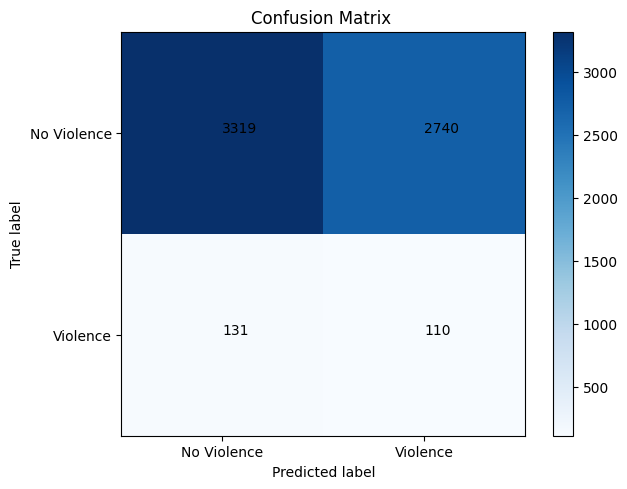

<Figure size 1000x1000 with 0 Axes>

In [90]:
## Model Confusion Matrix Plotting Section
plot_confusion_matrix(confusion_mat,classes,title='Confusion Matrix ')

print(type(confusion_mat))


plt.figure(figsize=(10,10))


## end of Plotting Section

In [91]:
testing_predictions = (test_results[1]).detach().argmax(dim=1)
testing_data_actual_values = (test_results[2])

classes = ["No Violence","Violence"]

confusion_mat = confusion_matrix(testing_predictions,testing_data_actual_values)

[[ 7 11]
 [ 0  0]]
<class 'numpy.ndarray'>


<Figure size 1000x1000 with 0 Axes>

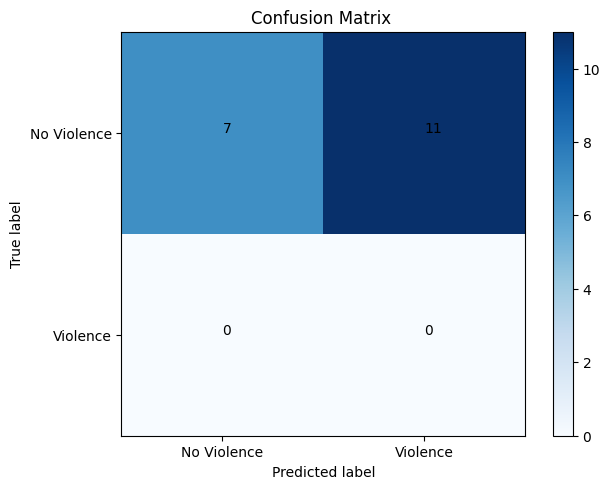

<Figure size 1000x1000 with 0 Axes>

In [92]:
## Model Confusion Matrix Plotting Section
plot_confusion_matrix(confusion_mat,classes,title='Confusion Matrix ')

print(type(confusion_mat))

plt.figure(figsize=(10,10))
plt.savefig(os.path.join('./Confusion Matrices', 'reg_model_confuse_matrix2.jpg'))

## end of Plotting Section

Model 3 - With Elu and extra 3 convolutional 3d layers

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

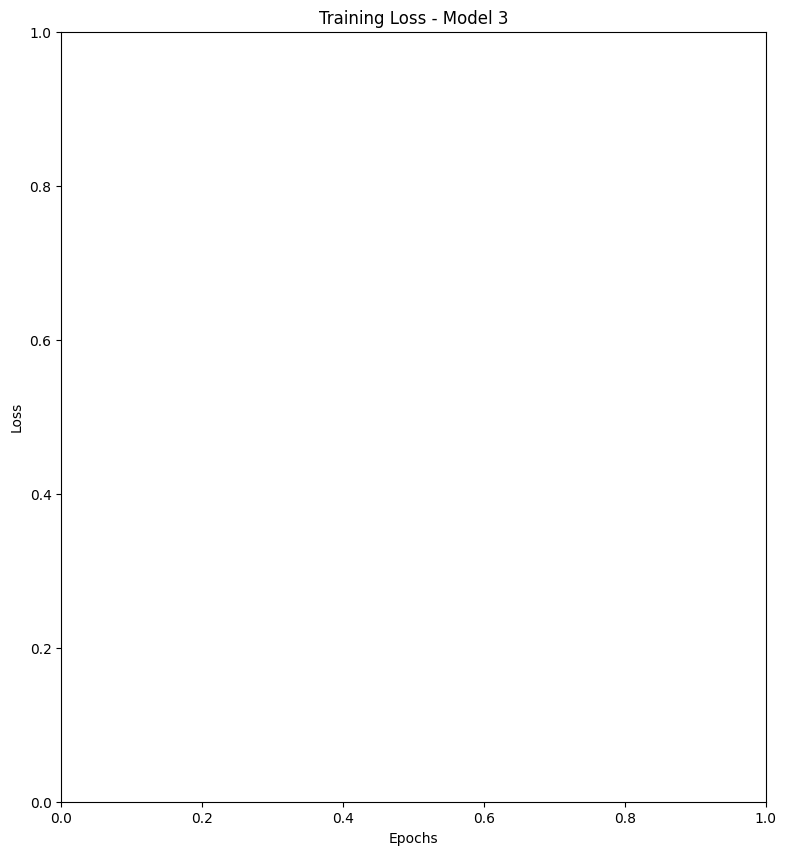

In [93]:
import torch.nn.functional as F
import torch.nn as layers
import torch.optim as optimizers
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from videoDataLoaderTest import dataset
from torch.utils.data import DataLoader, Dataset
import seaborn as sn
import time
import csv
import os
from plot_confusion_matrix import plot_confusion_matrix
import matplotlib.pyplot as plt 



from Regular_3D_2D_Hybrid_Extra_Conv2d import Regular_Plus_2dModel
from ELU_3D_2D_Hybrid_Extra_Conv2d import ELU_Plus_2dModel


class Hybrid_3D_2D_model_3(layers.Module): # layers.Module is what the Hybrid_3D_2d will inherit methods from
    # Input layers.Module 
    #
    #
    #
    # Output
    def __init__(self):
        # Input self 
        #
        #
        # 
        # Output 

        super(Hybrid_3D_2D_model_3, self).__init__() # 
        
        self.cn1 = layers.Conv3d(in_channels = 30,out_channels = 8,kernel_size = 7, padding = 3) # the images are in  coluor channel and 29 tensors 
        self.cn2 = layers.Conv3d(in_channels = 8,out_channels = 16,kernel_size = 5, padding = 2)
        self.cn3 = layers.Conv3d(in_channels = 16,out_channels=32, kernel_size = 3, padding = 1)
        
        self.cn1_additional = layers.Conv3d(in_channels = 32,out_channels=64, kernel_size = 3, padding = 1)
        self.cn2_additional = layers.Conv3d(in_channels = 64,out_channels=128, kernel_size = 3, padding = 1)
        self.cn3_additional = layers.Conv3d(in_channels = 128,out_channels=256, kernel_size = 3, padding = 1)
        self.cn4_2d = layers.Conv2d(in_channels = 256, out_channels = 64, kernel_size = 3, padding = 1) # padding for new layers need to be calculated 

        # size > reduce the input from 3d > 2d layer
        # 2d layer output to be flattened 
        
        self.dropout5 = layers.Dropout(0.4)
        self.fc5 = layers.Linear(64 * 64 * 64 ,256)
        #dropout > 0.4
        self.dropout6 = layers.Dropout(0.4)
        self.fc6 = layers.Linear(256,128)
        self.fc7 = layers.Linear(128,2)
        #dropout > 0.4

    def forward(self,x):

        output = self.cn1(x)
        output = F.elu(output)

        
        output = self.cn2(output)
        output = F.elu(output)

        
        output = self.cn3(output)
        output = F.elu(output) # activaltion function

        output = self.cn1_additional(output)
        output = F.elu(output) # activaltion function

        output = self.cn2_additional(output)
        output = F.elu(output) # activaltion function

        output = self.cn3_additional(output)
        output = F.elu(output) # activaltion function
    
        
        output = output.reshape(output.size(0), 256,64,64) 
        
        
        output = self.cn4_2d(output)
        
        output = F.elu(output)
        

        output = output.flatten(start_dim=1) # flattens output so that it can be fed into the linear layer

        output = self.fc5(output)
        output = F.elu(output)
        output = self.dropout5(output)


        output = self.fc6(output)
        output = F.elu(output)
        output = self.dropout6(output)
        

        output = self.fc7(output) 

        return output

 
y_loss = {}  # loss history
y_loss['train'] = []
y_loss['val'] = []
y_err = {}
y_err['train'] = []
y_err['val'] = []


x_epoch = []
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(121, title="Training Loss - Model 3") 
plt.ylabel('Loss')
plt.xlabel("Epochs")



def draw_curve_for_model_3_(current_epoch):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='Training Loss')
    if current_epoch == 0:
        ax0.legend()
        
    fig.savefig(os.path.join('./lossGraphs', 'train_loss_model_3.jpg'))


def train(model,device,the_dataloader, optim,epochs,dataset_size,phase,batch_size):
    
    training_data_predictions = torch.tensor([]) # creates a tensor for storing the predictions of teh model 
    training_data_actual_values = torch.tensor([])
    
    
    model.train() # setd the model to training mode 
    
    for epoch in range(epochs):


        running_loss = 0.0 # sets loss for this epoch to 0
        running_corrects = 0.0 # sets actual truths to 0 for this epoch

        print("Current epoch" + str(epoch))

        #start_time = time.time()

        loss_list = []    
        batch_list = []

        predicted_y = []
        actual_y = []

        for batch_index, (X,y) in enumerate(the_dataloader):
            #X,y = X.to(device), y.to(device) # X is the input y is teh ground truth
            
            optim.zero_grad() # sets the gradients to 0 
            prediction = model(X) # gets the predictions made by teh model
            
            training_data_predictions = torch.cat((training_data_predictions, prediction),dim=0) # combines the predictions of the model for this batch and the ones from before
            training_data_actual_values = torch.cat((training_data_actual_values, y),dim=0) # adds the tensors with the actual values

            
            # parts of code below adapted from 
            if X.size == 4:
                current_batch_size, channels, height, width = X.shape
            else:
                current_batch_size, framesFed ,channels, height, width = X.shape


            if current_batch_size < batch_size: # skips smaller batch to plot the graph
                continue


            _, preds = torch.max(prediction.data, 1)
            loss = layers.CrossEntropyLoss()

            
            loss_result = loss(prediction,y) # to be chenged to a different one since it does softmax 
            
            
            del X

            
            #loss =  # calculates the loss

            loss_result.backward() # updates the weights 
            optim.step() # 
            
            running_loss+=loss_result.item() * current_batch_size

            del loss
            running_corrects+=float(torch.sum(preds == y.data))
             
            
            if (batch_index*30) % 30 == 0: # 
                print(batch_index)
                training_result_format = 'batch:({:.0f})|loss:({:.4f}) '.format(batch_index,loss_result)
                print(training_result_format)

    epoch_loss = running_loss/dataset_size # ;loss fpr this epoch
    epoch_acc = running_corrects / dataset_size # 
    y_loss[phase].append(epoch_loss)
    y_err[phase].append(1.0  - epoch_acc)

    draw_curve_for_model_3_ (epoch) 

    return model,training_data_predictions,training_data_actual_values

def test_model_3_(model,device,the_dataloader, optim,epochs,dataset_size,phase,batch_size):

    testing_data_predictions = torch.tensor([]) # creates a tensor for storing the predictions of teh model 
    testing_data_actual_values = torch.tensor([])
    
    start_time = time.time()

    for batch_index, (X,y) in enumerate(the_dataloader):
        model.eval()
        
        torch.no_grad()

        prediction = model(X) # gets the predictions made by teh model
        testing_data_predictions = torch.cat((testing_data_predictions, prediction),dim=0) # combines the predictions of the model for this batch and the ones from before
        testing_data_actual_values = torch.cat((testing_data_actual_values, y),dim=0) # adds the tensors with the actual values

        # parts of code below adapted from 
        if X.size == 4:
            current_batch_size, channels, height, width = X.shape
        else:
            current_batch_size, framesFed ,channels, height, width = X.shape
        if current_batch_size < batch_size: # skips smaller batch to plot the graph
            continue
        _, preds = torch.max(prediction.data, 1)
        
        loss = layers.CrossEntropyLoss()
        
        loss_result = loss(prediction,y) # to be chenged to a different one since it does softmax 
        
        if (batch_index*30) % 30 == 0: # 
            print(batch_index)
            testing_result_format = 'batch:({:.0f})|loss:({:.4f}) '.format(batch_index,loss_result)
            print(testing_result_format)

        end_time = time.time()
        execution_time = end_time - start_time
        Regular_3D_2D_Hybrid_Time = open(('Model_3_Test_Time/time_file.txt'), "w" ) 
        Regular_3D_2D_Hybrid_Time.write("Testing time:" + str(execution_time) + "s" + "\n") 
        Regular_3D_2D_Hybrid_Time.close()

    return model,testing_data_predictions,testing_data_actual_values



ELUModel_3 = Hybrid_3D_2D_model_3()

optim = optimizers.SGD(ELUModel_3.parameters(),lr=0.01)# transfer learning paper > used 0.0005 for transfer learning 





In [94]:
training_results = train(ELUModel_3, 'cpu',load_training_data,optim,150,len(training_data),'train',batch_size=6) 

Current epoch0
0
batch:(0)|loss:(0.6983) 
1
batch:(1)|loss:(0.6883) 
2
batch:(2)|loss:(0.6977) 
3
batch:(3)|loss:(0.7033) 
4
batch:(4)|loss:(0.7102) 
5
batch:(5)|loss:(0.6892) 
6
batch:(6)|loss:(0.7014) 
Current epoch1
0
batch:(0)|loss:(0.6940) 
1
batch:(1)|loss:(0.6948) 
2
batch:(2)|loss:(0.6987) 
3
batch:(3)|loss:(0.6986) 
4
batch:(4)|loss:(0.6876) 
5
batch:(5)|loss:(0.7091) 
6
batch:(6)|loss:(0.6984) 
Current epoch2
0
batch:(0)|loss:(0.6861) 
1
batch:(1)|loss:(0.6808) 
2
batch:(2)|loss:(0.7034) 
3
batch:(3)|loss:(0.6928) 
4
batch:(4)|loss:(0.7026) 
5
batch:(5)|loss:(0.6789) 
6
batch:(6)|loss:(0.7012) 
Current epoch3
0
batch:(0)|loss:(0.6701) 
1
batch:(1)|loss:(0.6920) 
2
batch:(2)|loss:(0.7131) 
3
batch:(3)|loss:(0.6728) 
4
batch:(4)|loss:(0.7055) 
5
batch:(5)|loss:(0.6750) 
6
batch:(6)|loss:(0.7133) 
Current epoch4
0
batch:(0)|loss:(0.7243) 
1
batch:(1)|loss:(0.6904) 
2
batch:(2)|loss:(0.6832) 
3
batch:(3)|loss:(0.7130) 
4
batch:(4)|loss:(0.6822) 
5
batch:(5)|loss:(0.6811) 
6
batch

In [95]:
the_trained_3D_2D_Hybrid = training_results[0]

test_results = test_model_3_(the_trained_3D_2D_Hybrid, 'cpu',load_testing_data,optim,150,len(testing_data),'val',batch_size=6) 

training_predictions = (training_results[1]).detach().argmax(dim=1)
training_data_actual_values = (training_results[2])

classes = ["No Violence","Violence"]

confusion_mat = confusion_matrix(training_predictions,training_data_actual_values)
plt.figure(figsize=(10,10))

0
batch:(0)|loss:(2.4654) 
1
batch:(1)|loss:(0.0157) 
2
batch:(2)|loss:(0.6066) 


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

[[3387 1737]
 [  63 1113]]
<class 'numpy.ndarray'>


<Figure size 1000x1000 with 0 Axes>

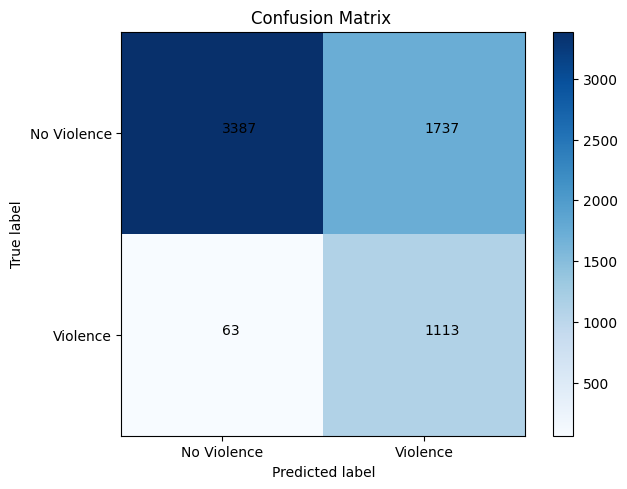

<Figure size 1000x1000 with 0 Axes>

In [96]:
## Model Confusion Matrix Plotting Section
plot_confusion_matrix(confusion_mat,classes,title='Confusion Matrix ')

print(type(confusion_mat))


plt.figure(figsize=(10,10))


## end of Plotting Section

In [97]:
testing_predictions = (test_results[1]).detach().argmax(dim=1)
testing_data_actual_values = (test_results[2])

classes = ["No Violence","Violence"]

confusion_mat = confusion_matrix(testing_predictions,testing_data_actual_values)

[[6 2]
 [1 9]]
<class 'numpy.ndarray'>


<Figure size 1000x1000 with 0 Axes>

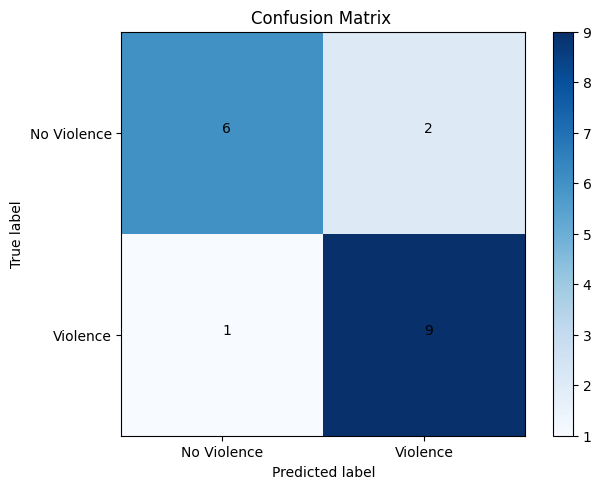

<Figure size 1000x1000 with 0 Axes>

In [98]:
## Model Confusion Matrix Plotting Section
plot_confusion_matrix(confusion_mat,classes,title='Confusion Matrix ')

print(type(confusion_mat))

plt.figure(figsize=(10,10))
plt.savefig(os.path.join('./Confusion Matrices', 'reg_model_confuse_matrix3.jpg'))

## end of Plotting Section